In [4]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [5]:
# Disponibilizando a tabela

df_original = pd.read_csv('Dataset')
df_original.head()

,Nome,Sobrenome,Email,UF,Cidade,Genero,Renda Média,Escolaridade,Estado Civil
0,Sergio,Costa,eduardo.oliveira@exemplo.com,DF,Brasília,Masculino,R$ 6.001 - R$ 8.000,Ensino Superior,Viúvo(a)
1,Eduardo,Melo,quintino.melo@exemplo.com,PE,Recife,Masculino,R$ 6.001 - R$ 8.000,Doutorado,Divorciado(a)
2,Sergio,Pereira,olivia.freitas@exemplo.com,CE,Fortaleza,Feminino,R$ 2.001 - R$ 4.000,Ensino Médio,Solteiro(a)
3,Gustavo,Oliveira,gustavo.melo@exemplo.com,SP,São Paulo,Feminino,R$ 2.001 - R$ 4.000,Doutorado,Viúvo(a)
4,Juliana,Oliveira,carlos.almeida@exemplo.com,DF,Brasília,Masculino,Acima de R$ 10.000,Ensino Superior,Divorciado(a)


In [6]:
# Verificando os tipos das colunas e se há elementos nulos

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Nome          1000 non-null   object
 1   Sobrenome     1000 non-null   object
 2   Email         1000 non-null   object
 3   UF            1000 non-null   object
 4   Cidade        1000 non-null   object
 5   Genero        1000 non-null   object
 6   Renda Média   1000 non-null   object
 7   Escolaridade  1000 non-null   object
 8   Estado Civil  1000 non-null   object
dtypes: object(9)
memory usage: 70.4+ KB


In [7]:
#Verificando se há duplicatas
duplicatas = df_original[df_original.duplicated()]
print(duplicatas)

Empty DataFrame
Columns: [Nome, Sobrenome, Email, UF, Cidade, Genero, Renda Média, Escolaridade, Estado Civil]
Index: []


**1 - Distribuição de Renda por Estado (UF):** Analisar a média e a mediana de renda por estado para identificar onde se concentram clientes com maior poder aquisitivo.

In [8]:
# Função para converter faixas de renda em valores numéricos
def converter_renda(renda):
    renda = renda.replace('R$', '').replace('.', '').strip()
    if 'Acima' in renda:
        return 10000  # Representando "Acima de R$ 10.000" como 10.000
    elif 'Até' in renda:
        return 1000  # Representando "Até R$ 1.000" como 1.000
    else:
        valores = renda.split(' - ')
        return (int(valores[0]) + int(valores[1])) / 2

# Aplicando a função de conversão na coluna 'Renda Média'
df_original['Renda Média Numérica'] = df_original['Renda Média'].apply(converter_renda)

# Calculando a média e a mediana de renda por estado (UF)
renda_estado = df_original.groupby('UF')['Renda Média Numérica'].agg(['mean', 'median']).sort_values(by='mean', ascending=False)

print(renda_estado)

           mean  median
UF                     
RN  6930.581395  9000.5
AM  6417.041667  7000.5
PE  6414.163793  7000.5
DF  6394.538462  7000.5
MA  6348.571429  7000.5
GO  6345.800000  7000.5
BA  6307.204545  7000.5
SC  6158.271930  7000.5
RJ  6097.120968  7000.5
TO  5928.901786  5000.5
MS  5884.413043  5000.5
CE  5863.972727  5000.5
SP  5837.040816  7000.5
MG  5830.906780  5000.5
PI  5690.873016  5000.5
PR  5609.445455  5000.5
RS  5583.656250  5000.5
PA  5510.978723  5000.5


**2 - Segmentação de Clientes por Estado Civil e Gênero:** Identificar a proporção de clientes casados, solteiros e divorciados por gênero e gerar gráficos comparativos. Essa análise pode ajudar a segmentar melhor campanhas direcionadas.

Genero          Feminino  Masculino
Estado Civil                       
Casado(a)      52.765957  47.234043
Divorciado(a)  45.769231  54.230769
Solteiro(a)    53.200000  46.800000
Viúvo(a)       49.019608  50.980392


<Figure size 1000x600 with 0 Axes>

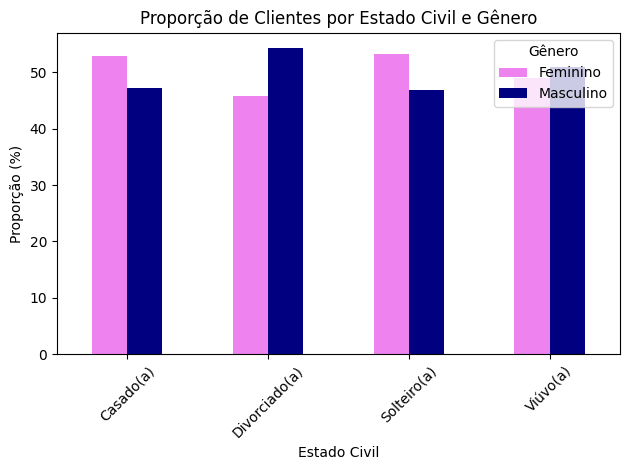

In [9]:
# Contando o número de clientes por Estado Civil e Gênero
segmentacao_estado_genero = df_original.groupby(['Estado Civil', 'Genero']).size().unstack()

# Calculando a proporção de clientes por Estado Civil e Gênero
proporcao_estado_genero = segmentacao_estado_genero.div(segmentacao_estado_genero.sum(axis=1), axis=0) * 100

print(proporcao_estado_genero)

# Criando gráfico de barras laterais com cores personalizadas
plt.figure(figsize=(10, 6))
proporcao_estado_genero.plot(kind='bar', stacked=False, color=['#ee82ee', '#000080'])
plt.title('Proporção de Clientes por Estado Civil e Gênero')
plt.xlabel('Estado Civil')
plt.ylabel('Proporção (%)')
plt.legend(title='Gênero')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**3 - Distribuição Geográfica dos Clientes:** Criar um mapa de calor para visualizar a concentração de clientes em diferentes cidades e estados, permitindo identificar regiões com maior presença.

In [10]:
# Contando o número de clientes por estado (UF)
clientes_por_uf = pd.DataFrame(df_original['UF'].value_counts())

# Clientes por estado
clientes_por_uf

,count
UF,
AM,72
MS,69
PI,63
RJ,62
MG,59
PE,58
SC,57
TO,56
MA,56


In [11]:
# Apenas ajustando o dataframe para dar join com o geojson
data = {
    'sigla': list(clientes_por_uf.index),
    'value': clientes_por_uf['count']
}
data_df = pd.DataFrame(data)
data_df

,sigla,value
UF,,
AM,AM,72
MS,MS,69
PI,PI,63
RJ,RJ,62
MG,MG,59
PE,PE,58
SC,SC,57
TO,TO,56
MA,MA,56


<Axes: ylabel='UF'>

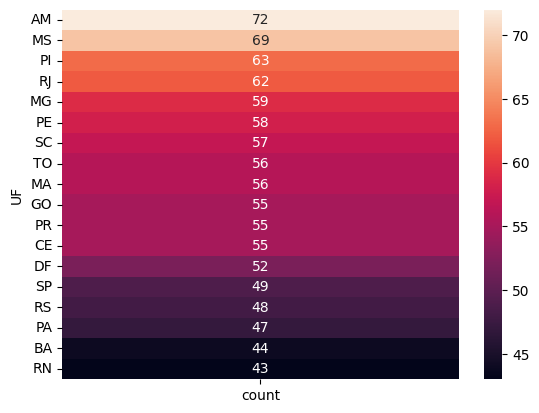

In [12]:
sns.heatmap(pd.DataFrame(clientes_por_uf),annot=True)

In [14]:
#TENTATIVA DE MAPA
mapa_brasil = gpd.read_file('brazil-states.geojson')

# Estrutura do mapa
mapa_brasil.head()

,id,name,sigla,regiao_id,codigo_ibg,cartodb_id,created_at,updated_at,geometry
0,1,Acre,AC,3,12,1,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ..."
1,2,Alagoas,AL,4,27,2,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ..."
2,3,Amazonas,AM,3,13,3,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2..."
3,4,Amapá,AP,3,16,4,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-51.18168 4.00889, -51.179 3.9..."
4,5,Bahia,BA,4,29,5,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-39.2882 -8.5629, -39.28229 -8..."


In [15]:
print(mapa_brasil.columns)

Index(['id', 'name', 'sigla', 'regiao_id', 'codigo_ibg', 'cartodb_id',
       'created_at', 'updated_at', 'geometry'],
      dtype='object')


In [16]:
# Renomear a coluna 'sigla' do shapefile para 'UF' para realizar a junção
#mapa_brasil = mapa_brasil.rename(columns={'sigla': 'UF'})

# Fazer a junção entre o mapa e o número de clientes por estado
mapa_brasil = mapa_brasil.join(pd.DataFrame(clientes_por_uf), on='sigla')

# Preencher os valores ausentes com 0
mapa_brasil['count'].fillna(0, inplace=True)

# Exibir o resultado após a junção
mapa_brasil.head()


C:\Users\BlueShift\AppData\Local\Temp\ipykernel_27744\3093772308.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mapa_brasil['count'].fillna(0, inplace=True)


,id,name,sigla,regiao_id,codigo_ibg,cartodb_id,created_at,updated_at,geometry,count
0,1,Acre,AC,3,12,1,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-73.60818 -7.20194, -72.86963 ...",0.0
1,2,Alagoas,AL,4,27,2,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-35.46516 -8.82549, -35.46626 ...",0.0
2,3,Amazonas,AM,3,13,3,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-67.32553 2.03012, -67.32234 2...",72.0
3,4,Amapá,AP,3,16,4,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-51.18168 4.00889, -51.179 3.9...",0.0
4,5,Bahia,BA,4,29,5,2015-02-09 16:46:01+00:00,2015-02-09 16:46:01+00:00,"MULTIPOLYGON (((-39.2882 -8.5629, -39.28229 -8...",44.0


In [17]:
print(mapa_brasil.columns)

Index(['id', 'name', 'sigla', 'regiao_id', 'codigo_ibg', 'cartodb_id',
       'created_at', 'updated_at', 'geometry', 'count'],
      dtype='object')


<Figure size 1000x1000 with 0 Axes>

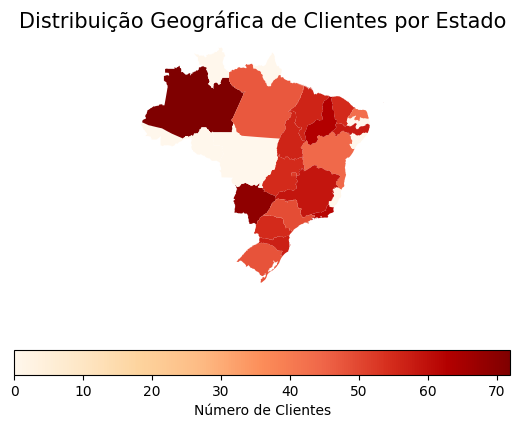

In [18]:
# Criar o mapa de calor usando a contagem de clientes
plt.figure(figsize=(10, 10))
mapa_brasil.plot(column='count', cmap='OrRd', legend=True, legend_kwds={'label': "Número de Clientes", 'orientation': "horizontal"})

# Personalizar o mapa
plt.title('Distribuição Geográfica de Clientes por Estado', fontsize=15)
plt.axis('off')  # Remover eixos

# Exibir o mapa
plt.show()

**4 - Análise de Outliers de Renda:** Identificar clientes com renda muito superior ou inferior à média para entender padrões atípicos que possam indicar perfis de clientes fora do usual para o negócio.

In [19]:
# Calculando a média e o desvio padrão da coluna de Renda Média Numérica
media_renda = df_original['Renda Média Numérica'].mean()
desvio_padrao_renda = df_original['Renda Média Numérica'].std()

# Limites para outliers (2 desvios-padrão)
limite_inferior = media_renda - 2 * desvio_padrao_renda
limite_superior = media_renda + 2 * desvio_padrao_renda

# Outliers (renda muito alta ou muito baixa)
outliers = df_original[(df_original['Renda Média Numérica'] < limite_inferior) | (df_original['Renda Média Numérica'] > limite_superior)]

# Exibir o resultado dos outliers
print(f'Clientes com renda muito abaixo de {limite_inferior:.2f} ou acima de {limite_superior:.2f}:')
print(outliers[['Nome', 'Sobrenome', 'UF', 'Renda Média', 'Renda Média Numérica']])


Clientes com renda muito abaixo de 198.77 ou acima de 11921.94:
Empty DataFrame
Columns: [Nome, Sobrenome, UF, Renda Média, Renda Média Numérica]
Index: []


**5 - Correlação entre Renda e Estado Civil:** Avaliar a correlação entre estado civil e renda média, verificando se existe algum padrão que ajude a imobiliária a personalizar suas ofertas.

In [20]:
# Estado civil para valores numéricos
estado_civil_map = {'Solteiro(a)': 1, 'Casado(a)': 2, 'Divorciado(a)': 3, 'Viúvo(a)': 4}
df_original['Estado Civil Numérico'] = df_original['Estado Civil'].map(estado_civil_map)

# Calculando a correlação entre estado civil numérico e renda
correlacao = df_original[['Estado Civil Numérico', 'Renda Média Numérica']].corr()

# Correlação
print(f'Correlação entre Estado Civil e Renda: \n{correlacao}')

# Média de renda por estado civil
media_renda_estado_civil = df_original.groupby('Estado Civil')['Renda Média Numérica'].mean()
print(f'Média de Renda por Estado Civil:\n{media_renda_estado_civil}')

Correlação entre Estado Civil e Renda: 
                       Estado Civil Numérico  Renda Média Numérica
Estado Civil Numérico               1.000000              0.023209
Renda Média Numérica                0.023209              1.000000
Média de Renda por Estado Civil:
Estado Civil
Casado(a)        6091.842553
Divorciado(a)    5883.048077
Solteiro(a)      6000.350000
Viúvo(a)         6270.947059
Name: Renda Média Numérica, dtype: float64


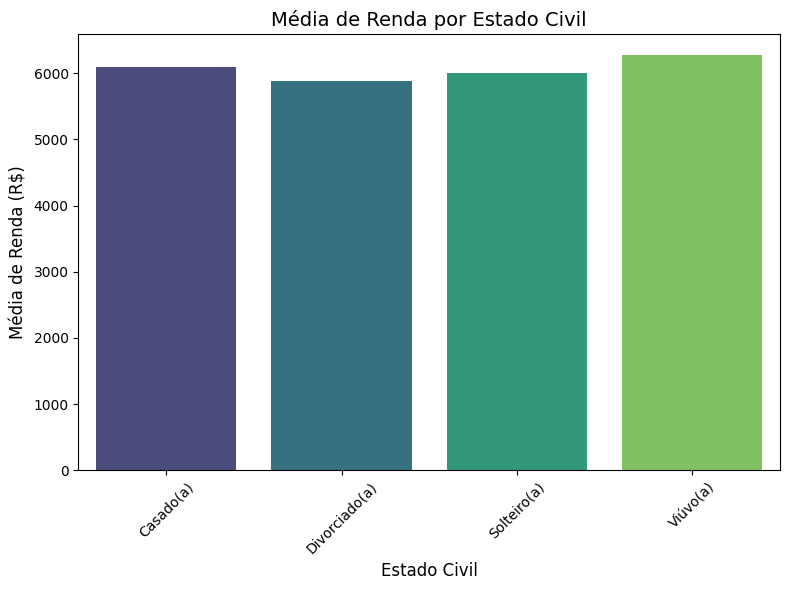

In [21]:
# Média de renda por estado civil
media_renda_estado_civil = df_original.groupby('Estado Civil')['Renda Média Numérica'].mean()

# Gráfico de barras para visualizar a média de renda por estado civil
plt.figure(figsize=(8, 6))
sns.barplot(x=media_renda_estado_civil.index, y=media_renda_estado_civil.values, hue=media_renda_estado_civil.index, palette='viridis', legend=False)

# Personalizando o gráfico
plt.title('Média de Renda por Estado Civil', fontsize=14)
plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Média de Renda (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
